#  Final: Classifying news stories as true or fake

#### Shovan Biswas, Randy Thompson, Ben Horvath

Some introductory text...

Our goal is to classify whether a piece  is fake or not _based on its substantive text content only_. The dataset is carefully prepared to remove any 'hints' to the model that detract from this goal (e.g., removing datelines).

The data can be downloaded from Kaggle at https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset. It is not present in the Github repo because of its size.

We make heavy use of tidyverse R functionality. Especially useful here is the `tidytext` package, which drastically simplifies the calculation of TF-IDF matrices; and the `caret` library for cross-validated modeling. Load necessary libraries:

In [136]:
library(caret)
library(dplyr)
library(ggplot2)
library(lubridate)  # easy dates
library(stringr)    # easy regex
library(textstem)   # stemming, lemmatization
library(tidytext)   # easy TF-IDF

Loading required package: koRpus.lang.en

Loading required package: koRpus

Loading required package: sylly

For information on available language packages for 'koRpus', run

  available.koRpus.lang()

and see ?install.koRpus.lang()




## Load the data

The data comes seperated in two CSVs of about equal size, one for true news stories, and other for fake. We load them, assign our dependent variable $y = \{fake, true\}$, and combine them.

In [87]:
fake <- read.csv('~/Downloads/Fake.csv', stringsAsFactors=FALSE) %>%
  mutate(y='fake')

real <- read.csv('~/Downloads/True.csv', stringsAsFactors=FALSE) %>%
  mutate(y='real')

# rename date to dt to keep R happy
df <- rbind(fake, real) %>%
  rename(dt = 'date') %>%
  mutate(dt = parse_date_time(dt, '%B %d, $Y'))

head(df, 1)

Warning message:
“Problem with `mutate()` input `dt`.
ℹ  45 failed to parse.
ℹ Input `dt` is `parse_date_time(dt, "%B %d, $Y")`.”
Warning message:
“ 45 failed to parse.”


,title,text,subject,dt,y
,<chr>,<chr>,<chr>,<dttm>,<chr>
1,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year! Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress. Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me? Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish?? Marlene (@marlene399) December 31, 2017You can t just say happy new year? Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love! Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his enemies and haters for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President? Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down. Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters? Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.",News,2017-12-31,fake


The dataset gives  us the title of the text, the text  itself, a classification of the news story, and the date of publishing.

## Exploratory analysis

Before modeling, we get to know our dataset more thoroughly. First, inspect the distribution of the dependent variable, which shows a balanced dataset.

In [3]:
table(df$y)


 fake  real 
23481 21417 

In [4]:
table(df$subject)


Government News       left-news     Middle-east            News        politics 
           1570            4459             778            9050            6841 
   politicsNews         US_News       worldnews 
          11272             783           10145 

The table below shows the distribution of subject these categories between fake and real news. We see that the fake news is labeled as either `politicsNews` or as `worldnews`, while the real news is labeled as everything else but those two. This suggests _subject should not be used as a model feature_.

In [13]:
prop.table(table(df$y, df$subject), 1)

      
       Government News  left-news Middle-east       News   politics
  fake      0.06686257 0.18989822  0.03313317 0.38541800 0.29134194
  real      0.00000000 0.00000000  0.00000000 0.00000000 0.00000000
      
       politicsNews    US_News  worldnews
  fake   0.00000000 0.03334611 0.00000000
  real   0.52631087 0.00000000 0.47368913

The `text` column will be ommitted in the NLP analysis because it is simply too much data for be easily computer on the present machines. However, we can still try to create simple features using regular expressions from the text. We examine a few of these below:

In [5]:
# Presence of Twitter handle
df$twitter_handle <- str_detect(df$text, '(?<!\\w)@[\\w+]{1,15}\\b')
prop.table(table(df$y, df$twitter_handle), 1)

      
            FALSE       TRUE
  fake 0.74132277 0.25867723
  real 0.98706635 0.01293365

The above shows that their is an association between the presence of a twitter handle and the reality of a news story.

Below shows a slighly weaker association with profanity (using a very crude and very incomplete regex):

In [8]:
PROFANITY <- 'fuck|shit|bastard|bitch|whore|goddamn'

df$profanity <- str_detect( tolower(df$text), PROFANITY)
prop.table(table(df$y, df$profanity), 1)

      
             FALSE        TRUE
  fake 0.944508326 0.055491674
  real 0.996965028 0.003034972

Finally, we can count the number of all-caps words in the text. Interestingly, there's no real difference in the distributions. Below we will see that this is due to the presence of acronyms in real news stories, as well as dateline in all-caps, e.g., WASHINGTON (Reuters). A better solution would be to count the length (in words) of all-caps phrases which do not appear often in real news stories.

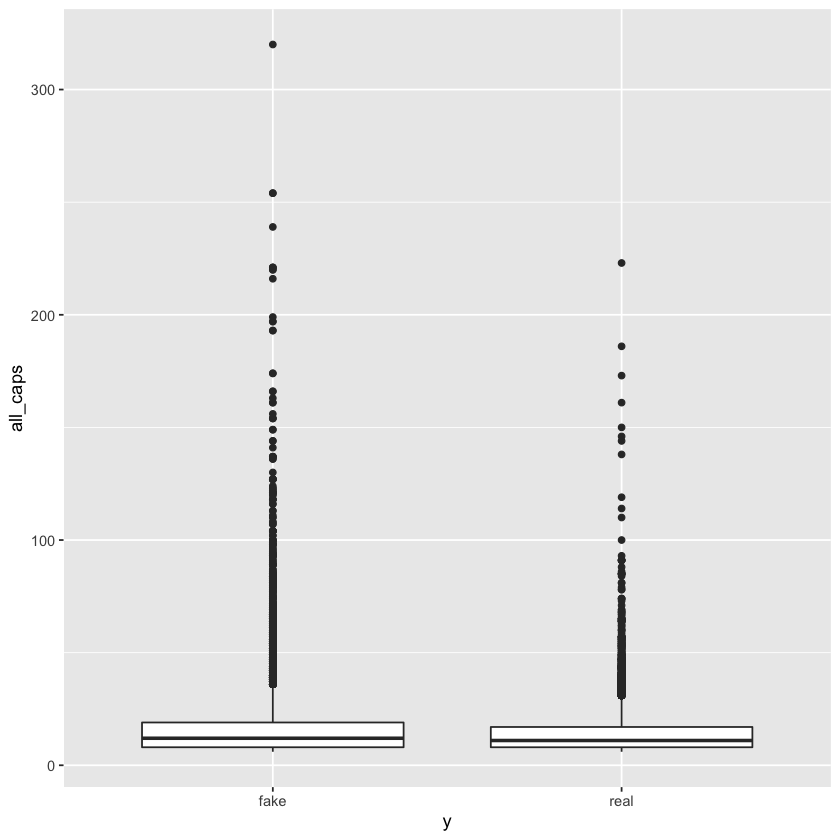

In [31]:
ALL_CAPS <- '(\\b[A-Z][A-Z]+|\\b[A-Z]\\b)'
df$all_caps <- str_count(df$text, ALL_CAPS)

ggplot(df %>% filter(all_caps > 5), aes(x=y, y=all_caps)) + geom_boxplot()

Finally, examine the distribution of fake and real news stories over time. There are no fake stories recorded until just after 2016, and following the spring of 2017 the real stories shoot up in quantity relative to the fake stories.

I'm not sure, but this could suggest the optimal sample should be  restricted to Jan. 2016 through June 2017, which would be about 26 thousand samples. **I'M NOT SURE**

`summarise()` regrouping output by 'dt' (override with `.groups` argument)

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


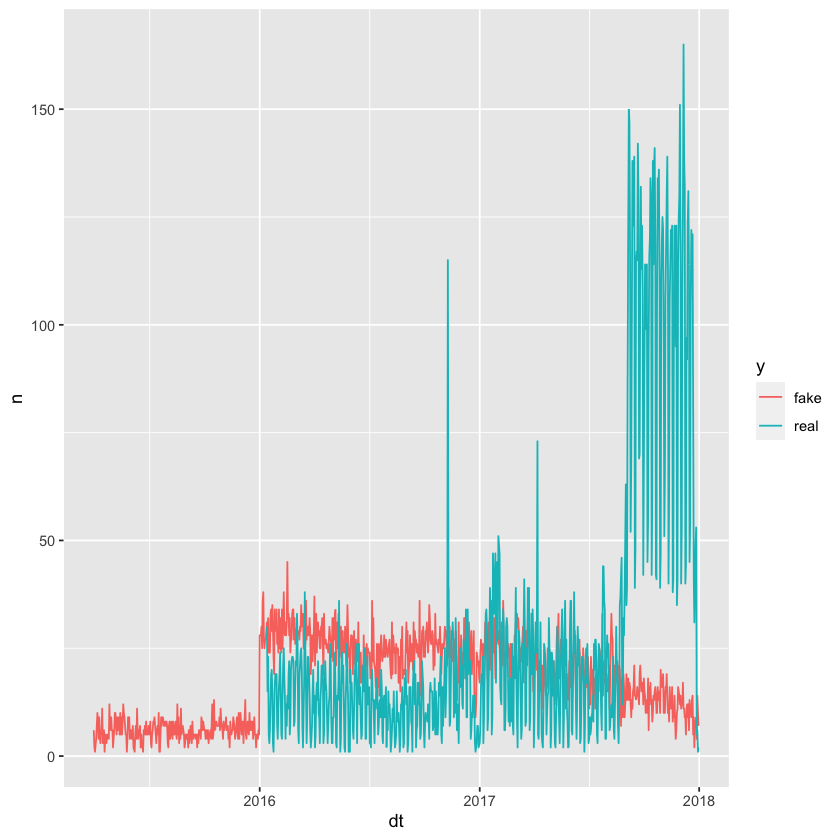

In [110]:
df %>%
  group_by(dt, y) %>%
  summarise(n=n_distinct(title)) %>%
  ggplot(aes(x=dt, y=n, colour=y)) + geom_line()

We will perform the same operations as above on the title:

In [111]:
df$title_twitter_handle <- str_detect(df$title, '(?<!\\w)@[\\w+]{1,15}\\b')
df$title_all_caps <- str_count(df$title, ALL_CAPS)
df$title_profanity <- str_detect( tolower(df$title), PROFANITY)

## Data cleaning

Using the story titles as IDs, there are duplicated stories. These are removed by keeping only the latest version:

In [77]:
length(df$title); length(unique(df$title))

[1] 44898

[1] 38729

In [78]:
df <- df %>%
  arrange(title, desc(dt)) %>%
  group_by(title) %>%
  slice(which.max(dt))

length(df$title); length(unique(df$title))

[1] 38688

[1] 38688

All of the real news stories are from Reuters, and all Reuters news stories begin with a dateline, e.g., WASHINGTON (Rueters). These are removed by a very simple Regex that matches the beginning of the story up to the first hyphen. It appears to be effective enough. Additionally, we remove any other mentions of 'Reuters' just to be sure, and numbers:

In [158]:
df <- df %>%
  mutate(title = str_remove(title, '^[^\\-]*\\-\\s+'),
         title = str_remove(tolower(title), 'reuters'),
         title = str_remove(title, '[0-9]+'))

Often, at this point in NLP process, we normally remove punctuation and a list of stop words. However, it may be that there are differences in punctuations and stop words between fake and real news. We thus retain them.

### Tokenize

However, we will be conducting other stemming, requiring tokenization. Recall that  we are concerned only with the title for now:

In [159]:
tokens <- df %>%
  select(y, title) %>%
  unnest_tokens(word, title, drop=FALSE)

head(tokens)

,y,title,word
,<chr>,<chr>,<chr>
1,fake,donald trump sends out embarrassing new year’s eve message; this is disturbing,donald
1.1,fake,donald trump sends out embarrassing new year’s eve message; this is disturbing,trump
1.2,fake,donald trump sends out embarrassing new year’s eve message; this is disturbing,sends
1.3,fake,donald trump sends out embarrassing new year’s eve message; this is disturbing,out
1.4,fake,donald trump sends out embarrassing new year’s eve message; this is disturbing,embarrassing
1.5,fake,donald trump sends out embarrassing new year’s eve message; this is disturbing,new


### Stemming

We will, of course, conduct stemming on the title, using the `textstem` library, which uses a stemmer based on the `libstemmer` C library developed in the early 2000s.

In [160]:
stems <- tokens %>%
  mutate(stemmed = stem_words(word))

head(stems)

,y,title,word,stemmed
,<chr>,<chr>,<chr>,<chr>
1,fake,donald trump sends out embarrassing new year’s eve message; this is disturbing,donald,donald
2,fake,donald trump sends out embarrassing new year’s eve message; this is disturbing,trump,trump
3,fake,donald trump sends out embarrassing new year’s eve message; this is disturbing,sends,send
4,fake,donald trump sends out embarrassing new year’s eve message; this is disturbing,out,out
5,fake,donald trump sends out embarrassing new year’s eve message; this is disturbing,embarrassing,embarrass
6,fake,donald trump sends out embarrassing new year’s eve message; this is disturbing,new,new


###  Lemmatize

Next, we clean up the tokens further by lemmatization, again using the `textstem` library:

In [161]:
lemmas <- stems %>%
  mutate(lemma = lemmatize_words(stemmed))

head(lemmas)

,y,title,word,stemmed,lemma
,<chr>,<chr>,<chr>,<chr>,<chr>
1,fake,donald trump sends out embarrassing new year’s eve message; this is disturbing,donald,donald,donald
2,fake,donald trump sends out embarrassing new year’s eve message; this is disturbing,trump,trump,trump
3,fake,donald trump sends out embarrassing new year’s eve message; this is disturbing,sends,send,send
4,fake,donald trump sends out embarrassing new year’s eve message; this is disturbing,out,out,out
5,fake,donald trump sends out embarrassing new year’s eve message; this is disturbing,embarrassing,embarrass,embarrass
6,fake,donald trump sends out embarrassing new year’s eve message; this is disturbing,new,new,new


## Feature engineering

**ADD ADDITIONAL FEATURES HERE, INCORPORATE FROM ABOVE?**

Now we  calculate TF-IDF. Those scores and all other features are incorporated to a data frame called `X` for later machine learning.

In [183]:
token_count <- lemmas %>%
  count(title, y, lemma, sort=TRUE) %>%
  ungroup()
head(token_count)

,title,y,lemma,n
,<chr>,<chr>,<chr>,<int>
1,sources,real,sourc,31
2,highlights: the trump presidency on april at :30 p.m. edt/0130 gmt on friday,real,on,16
3,factbox: trump fills top jobs for his administration,real,administr,14
4,factbox: trump fills top jobs for his administration,real,factbox,14
5,factbox: trump fills top jobs for his administration,real,fill,14
6,factbox: trump fills top jobs for his administration,real,for,14


In [184]:
total_words <- token_count %>%
  group_by(title, y) %>%
  summarise(total = sum(n), .groups='keep')
head(total_words)

title,y,total
<chr>,<chr>,<int>
donald trump gets his a** handed to him by a -year-old girl (video),fake,14
ex-gop congressman shreds fellow republicans for not ‘howling’ for trump’s impeachment (video),fake,13
trump gets stomped for whining about president obama using air force one on campaign trail,fake,15
watch: democratic rep delivers scathing rebuke of trumpcare bill to thunderous applause on house floor,fake,15
amazingly racist and bigoted things trump supporters actually believe (video),fake,10
broke a new climate change record and it’s bad news for the planet,fake,13


In [243]:
token_count <- token_count %>%
  bind_tf_idf(lemma, title, n)

# Remove tokens with less than 10 instances
tc <- token_count %>%
  group_by(lemma) %>%
  summarise(n=sum(n), .groups='keep') %>%
  filter(n > 10)

token_count <- token_count %>%
  filter(lemma %in% tc$lemma)

head(token_count)

,title,y,lemma,n,tf,idf,tf_idf
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,sources,real,sourc,31,1.0000000,4.590911,4.5909108
2,highlights: the trump presidency on april at :30 p.m. edt/0130 gmt on friday,real,on,16,0.1428571,1.839756,0.2628222
3,factbox: trump fills top jobs for his administration,real,administr,14,0.1250000,5.065004,0.6331256
4,factbox: trump fills top jobs for his administration,real,factbox,14,0.1250000,4.990019,0.6237523
5,factbox: trump fills top jobs for his administration,real,fill,14,0.1250000,6.733531,0.8416914
6,factbox: trump fills top jobs for his administration,real,for,14,0.1250000,1.853698,0.2317123


In [244]:
# Make into a wide, tidy data frame for machine learning
X <- token_count %>%
  select(title, y, lemma, tf_idf) %>% 
  filter(lemma != 'title',
         lemma != 'y') %>%  # remove because I'm already using 'title' and 'y'
  unique %>%
  tidyr::spread(lemma, tf_idf) %>%
  janitor::clean_names() %>%  # VERY HANDY FUNCTION!
  replace(is.na(.), 0) %>%
  select(!contains('_2'))

In [245]:
dim(X)
head(X[, c(1,2,601, 709, 804, 945)])
prop.table(table(X$y))

[1] 38638  4158

,title,y,challeng,collin,conwai,defeat
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,donald trump gets his a** handed to him by a -year-old girl (video),fake,0,0,0,0
2,ex-gop congressman shreds fellow republicans for not ‘howling’ for trump’s impeachment (video),fake,0,0,0,0
3,trump gets stomped for whining about president obama using air force one on campaign trail,fake,0,0,0,0
4,watch: democratic rep delivers scathing rebuke of trumpcare bill to thunderous applause on house floor,fake,0,0,0,0
5,amazingly racist and bigoted things trump supporters actually believe (video),fake,0,0,0,0
6,broke a new climate change record and it’s bad news for the planet,fake,0,0,0,0



     fake      real 
0.4632745 0.5367255 

Our final TF-IDF matrix has almost 39,000 articles (rows), 4156 token TF-IDF scores (columns), and a reasonably balanced distribution of fake and real news.

**ADD ADDITIONAL FEATURES HERE!**

## Modeling

With almost 14,000 potential variable, we would like to drop those to a more reasonable set. First, remove low variance using the ratio of a variable's unique values to its sample size. By default, `nearZeroVar` suggests all the variables have sparse variancel; this is fixed by modifying the default value for `uniqueCut`:

In [269]:
# Remove low variance variables
low_variance <- nearZeroVar(X, uniqueCut=.045)
print(low_variance)

   [1]    3    4    6    7    8   10   11   12   13   14   15   16   17   18
  [15]   19   22   23   24   25   26   28   29   30   31   32   33   34   35
  [29]   36   37   38   40   41   42   43   46   50   52   53   54   55   56
  [43]   57   58   59   60   61   62   64   65   66   67   68   69   70   71
  [57]   72   73   74   75   76   77   78   79   80   81   82   83   84   89
  [71]   92   93   94   96   97   98  100  101  103  104  105  106  107  108
  [85]  109  110  111  112  113  114  115  116  117  118  120  122  123  125
  [99]  126  127  128  129  131  132  133  134  135  136  137  138  139  140
 [113]  141  142  143  144  147  148  150  151  152  153  154  155  156  157
 [127]  159  160  161  162  163  164  165  167  168  169  171  172  176  179
 [141]  181  182  183  184  185  186  187  188  189  190  191  192  193  195
 [155]  196  197  199  200  201  202  204  206  207  208  209  210  211  212
 [169]  213  214  215  216  217  221  223  224  225  226  227  228  229  230

In [270]:
length(low_variance)

[1] 3361

In [273]:
X <- X[,-low_variance]
ncol(X)

### Random Forest

**TEMPLATE FOR MODELING**

Using the `ranger`  package, a faster and more modern implementation of random forests

Maximize for ROC:

In [281]:
ctrl <- trainControl(method='repeatedcv',
                     number=2,  # number of folds for each run: change this for final run
                     repeats=1,  # number of times to repeat CV: change this for final run
                     classProbs=TRUE,
                     savePredictions=TRUE,
                     summaryFunction = twoClassSummary)

# good guesses for mtry are sqrt(p) and log2(p)
tunegrid <- expand.grid(mtry=c(9, 20),
                        splitrule=c('gini'),
                        min.node.size=c(1, 5))
 
set.seed(1804)
m0 <- train(y ~ .,
            data=X[, c(2:103)],   # REMOVE THIS SUBSETTING FOR REAL MODEL
            tuneGrid=tunegrid,
            method='ranger',
            num.trees=1000,
            importance='impurity',
            trControl=ctrl,
            metric='ROC')

print(m0)



Growing trees.. Progress: 48%. Estimated remaining time: 33 seconds.
Growing trees.. Progress: 97%. Estimated remaining time: 2 seconds.
Growing trees.. Progress: 23%. Estimated remaining time: 1 minute, 41 seconds.
Growing trees.. Progress: 48%. Estimated remaining time: 1 minute, 7 seconds.
Growing trees.. Progress: 72%. Estimated remaining time: 35 seconds.
Growing trees.. Progress: 95%. Estimated remaining time: 6 seconds.
Growing trees.. Progress: 48%. Estimated remaining time: 33 seconds.
Growing trees.. Progress: 96%. Estimated remaining time: 2 seconds.
Growing trees.. Progress: 21%. Estimated remaining time: 1 minute, 59 seconds.
Growing trees.. Progress: 41%. Estimated remaining time: 1 minute, 30 seconds.
Growing trees.. Progress: 61%. Estimated remaining time: 59 seconds.
Growing trees.. Progress: 81%. Estimated remaining time: 28 seconds.
Growing trees.. Progress: 51%. Estimated remaining time: 30 seconds.
Growing trees.. Progress: 24%. Estimated remaining time: 1 minute, 

Warning message:
“model fit failed for Fold2.Rep1: mtry=20, splitrule=gini, min.node.size=5 Error in ranger::ranger(dependent.variable.name = ".outcome", data = x,  : 
  User interrupt or internal error.
”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


Growing trees.. Progress: 18%. Estimated remaining time: 2 minutes, 17 seconds.
Growing trees.. Progress: 37%. Estimated remaining time: 1 minute, 43 seconds.
Growing trees.. Progress: 56%. Estimated remaining time: 1 minute, 12 seconds.
Growing trees.. Progress: 73%. Estimated remaining time: 46 seconds.
Growing trees.. Progress: 91%. Estimated remaining time: 15 seconds.


Random Forest 

38638 samples
  101 predictor
    2 classes: 'fake', 'real' 

No pre-processing
Resampling: Cross-Validated (2 fold, repeated 1 times) 
Summary of sample sizes: 19319, 19319 
Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens       Spec     
   9    1              0.8338856  0.6296648  0.9106953
   9    5              0.8338819  0.6300000  0.9094898
  20    1              0.8332784  0.6267039  0.9173498
  20    5              0.8319198  0.6367598  0.9115633

Tuning parameter 'splitrule' was held constant at a value of gini
ROC was used to select the optimal model using the largest value.
The final values used for the model were mtry = 9, splitrule = gini
 and min.node.size = 1.

In [282]:
print(m0)

Random Forest 

38638 samples
  101 predictor
    2 classes: 'fake', 'real' 

No pre-processing
Resampling: Cross-Validated (2 fold, repeated 1 times) 
Summary of sample sizes: 19319, 19319 
Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens       Spec     
   9    1              0.8338856  0.6296648  0.9106953
   9    5              0.8338819  0.6300000  0.9094898
  20    1              0.8332784  0.6267039  0.9173498
  20    5              0.8319198  0.6367598  0.9115633

Tuning parameter 'splitrule' was held constant at a value of gini
ROC was used to select the optimal model using the largest value.
The final values used for the model were mtry = 9, splitrule = gini
 and min.node.size = 1.


In [287]:
# shows the performance on each repetition of the modeling proess
# can get mean performance, std dev of each performance, or plot
# a histogram, giving complete overview of performance on multiple
# slices and dices of the training dataset
head(m0$resample)

# Averaged cross-validation scores, most representative of performance
mean(m0$resample$ROC); mean(m0$resample$Sens); mean(m0$resample$Spec)

,ROC,Sens,Spec,Resample
,<dbl>,<dbl>,<dbl>,<chr>
1,0.8325625,0.6359777,0.9043302,Fold1.Rep1
2,0.8352088,0.6233520,0.9170605,Fold2.Rep1


[1] 0.8338856

[1] 0.6296648

[1] 0.9106953

In [284]:
varImp(m0)

ranger variable importance

  only 20 most important variables shown (out of 101)

         Overall
a        100.000
and       85.411
about     45.215
after     41.066
`break`   28.533
be        28.324
at        27.958
ar        25.278
black     23.205
bill      19.825
american  14.343
america   14.225
against   11.791
back      11.228
berni     10.643
becaus     9.438
attack     9.373
anti       8.781
aid        8.220
all        7.786

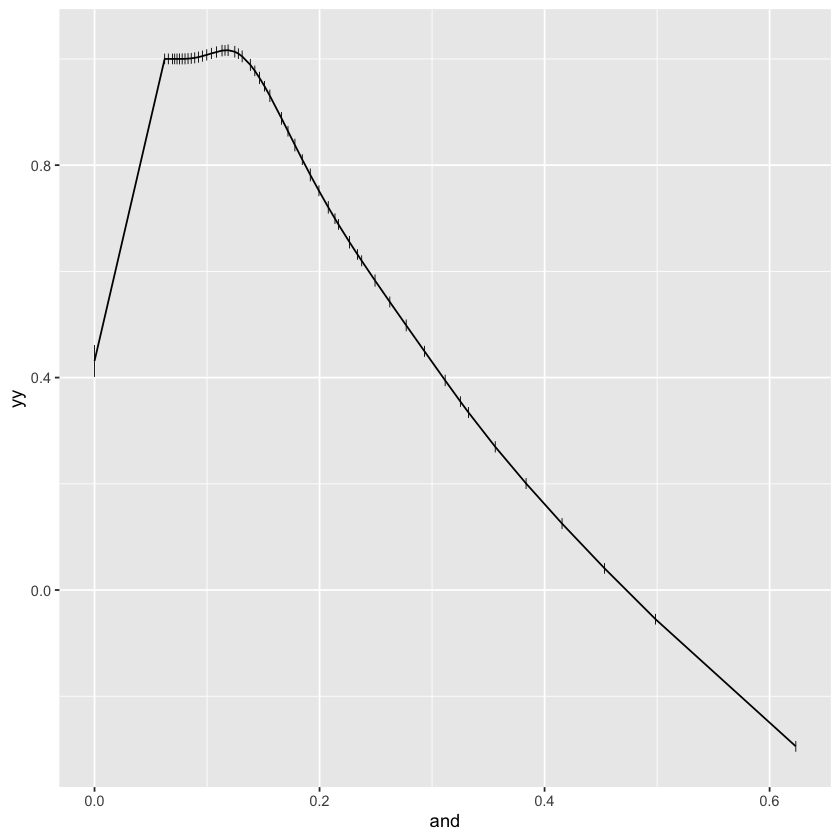

In [286]:
# This is a conveniant way to visualize 'direct probabilities' from the raw data,
# (NOT the model)

Y <- X %>%
  mutate(yy = if_else(y == 'fake', TRUE, FALSE))  # has to be a factor for Hmisc

library(Hmisc)
ggplot(Y, aes(x=and, y=yy )) +
  histSpikeg(yy ~ and, lowess=TRUE, data=Y)